# Evaluation Metrics for Classification

## Evaluation metrics: session overview

Metric - is a function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [2]:
!wget $data -O data-week-4.csv

--2025-10-23 10:41:30--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data-week-4.csv’

data-week-4.csv     100%[===================>] 954.59K  2.64MB/s    in 0.4s    

2025-10-23 10:41:31 (2.64 MB/s) - ‘data-week-4.csv’ saved [977501/977501]



In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv('data-week-4.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

## Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [10]:
len(y_val)

1409

In [11]:
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

In [12]:
1132/ 1409

0.8034066713981547

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

In [15]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


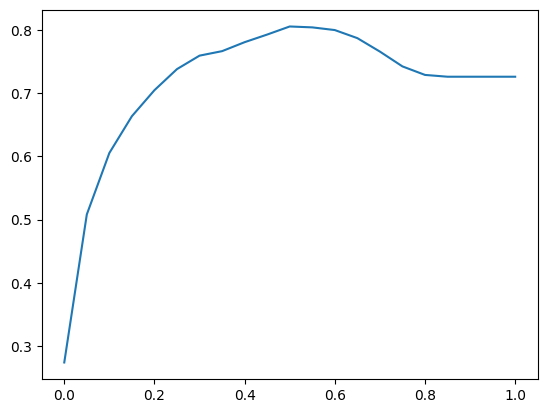

In [16]:
plt.plot(thresholds, scores)

In [17]:
from collections import Counter

In [18]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [19]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [20]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [21]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [22]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [23]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[923, 100],
       [174, 212]])

In [24]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

## Precision and Recall

Precision tell us the fraction of positive predictions that are correct. It takes into account only the positive class (TP and FP - second column of the confusion matrix), as is stated in the following formula:

$P=\frac{TP}{TP+FP}$

In [25]:
p = tp / (tp + fp)
p

np.float64(0.6794871794871795)

Recall measures the fraction of correctly identified postive instances. It considers parts of the positive and negative classes (TP and FN - second row of confusion table). The formula of this metric is presented below:

$R=\frac{TP}{TP+FN}$

In [26]:
recall = tp / (tp + fn)
recall

np.float64(0.5492227979274611)

In this problem, the **precision** and **recall** values were 67% and 54% respectively. So, these measures reflect some errors of our model that **accuracy** did not notice due to the **class imbalance**.

![image](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/images/classification_metrics.png?raw=truem)

### MNEMONICS:

**Precision**: From the predicted positives, how many we predicted right.

**Recall**: From the real positives, how many we predicted right.

## ROC Curves

ROC stands for Receiver Operating Characteristic, and this idea was applied during the Second World War for evaluating the strength of radio detectors. This measure considers **False Positive Rate** (FPR) and **True Postive Rate** (TPR), which are derived from the values of the confusion matrix.

FPR is the fraction of false positives (FP) divided by the total number of negatives (FP and TN - the first row of confusion matrix), and we want to `minimize` it. The formula of FPR is the following:

$FPR=\frac{TP}{TN+FP}$

In the other hand, **TPR** or **Recall** is the fraction of true positives (TP) divided by the total number of positives (FN and TP - second row of confusion table), and we want to `maximize` this metric. The formula of this measure is presented below:

$TPR=\frac{TP}{TP+FN}$

![image](https://github.com/DataTalksClub/machine-learning-zoomcamp/raw/master/04-evaluation/images%2FTPR_FPR.png)

ROC curves consider Recall and FPR under all the possible thresholds. If the threshold is 0 or 1, the FPR and Recall scores are the opposite of the threshold (1 and 0 respectively), but they have different meanings, as we explained before.

We need to compare the ROC curves against a point of reference to evaluate its performance, so the corresponding curves of random and ideal models are required. It is possible to plot the ROC curves with FPR and Recall scores vs thresholds, or FPR vs Recall.

**Classes and methods:**

- `np.repeat([x,y], [z,w])` - returns a numpy array with a z number of x values first, and then a w number of y values.
- `roc_curve(x, y)` - sklearn.metrics class for calculating the false positive rates, true positive rates, and thresholds, given a target x dataset and a predicted y dataset.

### TPR and FRP

In [27]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [28]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09775171065493646)

In [29]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [30]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

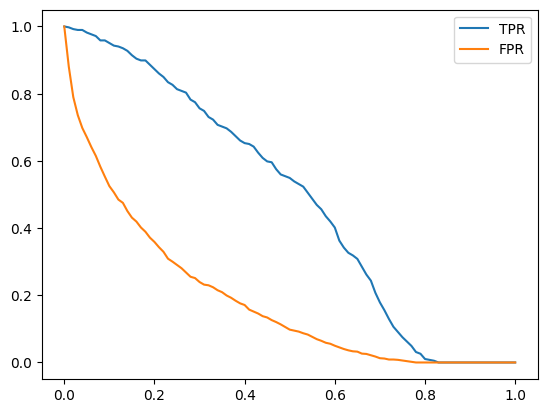

In [31]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [32]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [33]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [34]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [35]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

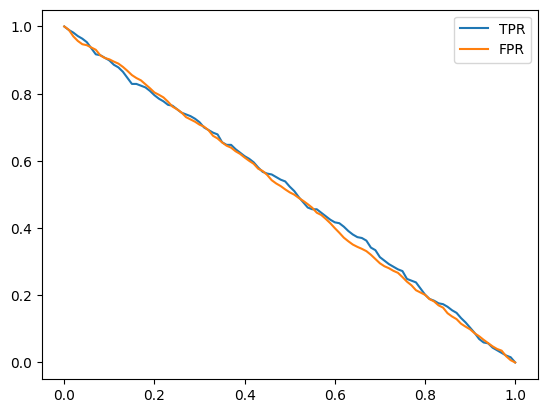

In [36]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [37]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [38]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [39]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [40]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [41]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


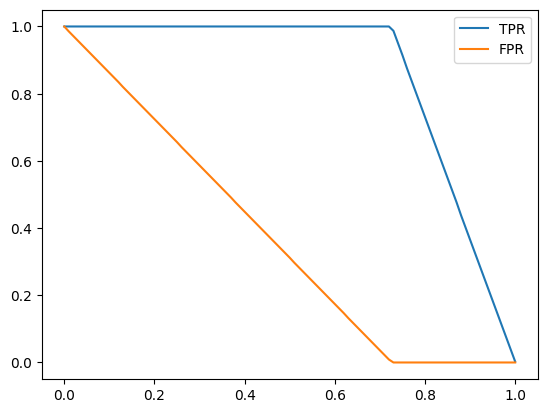

In [42]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

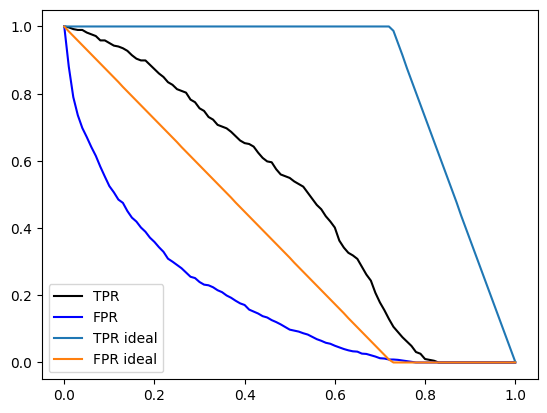

In [43]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

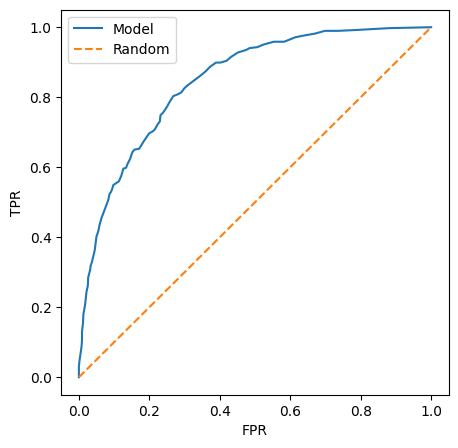

In [44]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [45]:
from sklearn.metrics import roc_curve

In [46]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

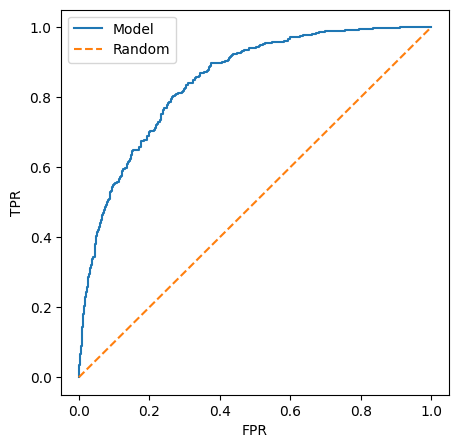

In [47]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## ROC AUC

The Area under the ROC curves can tell us how good is our model with a single value. The AUROC of a random model is 0.5, while for an ideal one is 1.

In other words, AUC can be interpreted as the probability that a randomly selected positive example has a greater score than a randomly selected negative example.

**Classes and methods:**

`auc(x, y)` - sklearn.metrics class for calculating area under the curve of the x and y datasets. For ROC curves x would be false positive rate, and y true positive rate.
`roc_auc_score(x, y)` - sklearn.metrics class for calculating area under the ROC curves of the x false positive rate and y true positive rate datasets.
`randint(x, y, size=z)` - np.random class for generating random integers from the “discrete uniform” distribution; from `x` (inclusive) to `y` (exclusive) of size `z`.

In [48]:
from sklearn.metrics import auc

In [49]:
auc(fpr, tpr)

0.8465981898206534

In [50]:
auc(df_scores.fpr, df_scores.tpr)

0.8463208889834327

In [51]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [52]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8465981898206534

In [53]:
from sklearn.metrics import roc_auc_score

In [54]:
roc_auc_score(y_val, y_pred)

0.8465981898206534

In [55]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [57]:
import random

In [58]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84815

In [59]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84892)

## Cross-Validation

**Cross-validations** refers to evaluating the same model on different subsets of a dataset, getting the average prediction, and spread within predictions. This method is applied in the **parameter tuning** step, which is the process of selecting the best parameter.

In this algorithm, the full training dataset is divided into **k partitions**, we train the model in k-1 partitions of this dataset and evaluate it on the remaining subset. Then, we end up evaluating the model in all the k folds, and we calculate the average evaluation metric for all the folds.

In general, if the dataset is large, we should use the hold-out validation dataset strategy. In the other hand, if the dataset is small or we want to know the standard deviation of the model across different folds, we can use the cross-validation approach.

**Libraries, classes and methods:**

`Kfold(k, s, x)` - sklearn.model_selection class for calculating the cross validation with k folds, s boolean attribute for shuffle decision, and an x random state
`Kfold.split(x)` - sklearn.Kfold method for splitting the x dataset with the attributes established in the Kfold's object construction.
for i in tqdm() - library for showing the progress of each i iteration in a for loop.

In [60]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [61]:
dv, model = train(df_train, y_train, C=0.001)

In [62]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [63]:
y_pred = predict(df_val, dv, model)

In [64]:
from sklearn.model_selection import KFold

In [65]:
!pip install tqdm


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [66]:
from tqdm.auto import tqdm

In [67]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009


/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/st

C=0.01 0.840 +- 0.008


/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/st

C=0.1 0.842 +- 0.007


/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/st

C=0.5 0.842 +- 0.007


/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/st

C=1 0.842 +- 0.007


/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/st

C=5 0.842 +- 0.007


/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/st

C=10 0.842 +- 0.007


/home/ramil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
scores

[0.8447064549300971,
 0.8450763971659383,
 0.8333895243829019,
 0.8348488360938799,
 0.8517421794107496]

In [69]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8584032088573997

## Summary

- Metric - a single number that describes the performance of a model
- Accuracy - fraction of correct answers; sometimes misleading
- Precision and recall are less misleading when we have class inbalance
- ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
- K-Fold CV - more reliable estimate for performance (mean + std)